<a href="https://colab.research.google.com/github/Faiga91/paper-4/blob/colab/SenseGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/Faiga91/paper-4.git

Cloning into 'paper-4'...
remote: Enumerating objects: 313, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 313 (delta 50), reused 55 (delta 29), pack-reused 231
Receiving objects: 100% (313/313), 15.54 MiB | 26.05 MiB/s, done.
Resolving deltas: 100% (182/182), done.


In [2]:
%cd paper-4/

/content/paper-4


In [3]:
import imp
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from get_data import MyDataset
import helping_functions
import sensegan
torch.manual_seed(0) # Set for testing purposes, please do not change!

In [5]:
# Load the intel lab data. 
my_training_data = MyDataset()
df_train = my_training_data.train
df_train = df_train.float()

In [6]:
# Normalization
ori_data, min_val, max_val = helping_functions.MinMaxScaler(df_train)

In [10]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 10
z_dim = 1
display_step = 500
batch_size = 64
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
lr = 0.0002
c_lambda = 10
crit_repeats = 4

# Load MNIST dataset as tensors
dataloader = DataLoader( ori_data[:-43],
    batch_size=batch_size,
    shuffle=False)

device = 'cuda'

In [8]:
gen = sensegan.Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = sensegan.Critic().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.ConvTranspose1d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm1d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 2, step 500: Generator loss: 6.1516066944599155, critic loss: -5.937460623383522


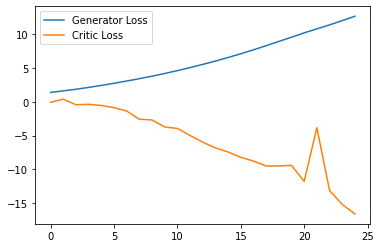

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 4, step 1000: Generator loss: 23.79722257041931, critic loss: -33.674204869747165


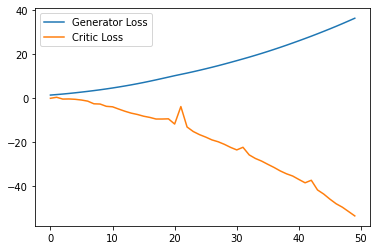

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 7, step 1500: Generator loss: 55.374463218688966, critic loss: -82.63549025344848


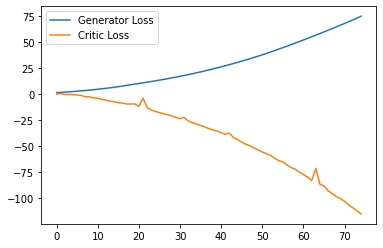

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 9, step 2000: Generator loss: 100.0934525756836, critic loss: -155.65851592636108


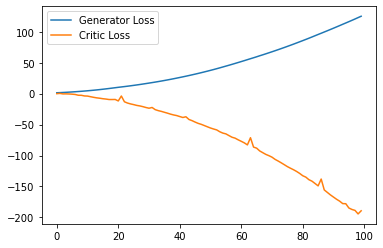

In [11]:
cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = sensegan.get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(torch.transpose(real, 0, 1))

            epsilon = torch.rand(len(real), 1, 1, device=device, requires_grad=True)
            gradient = sensegan.get_gradient(crit, torch.transpose(real, 0, 1), fake.detach(), epsilon)
            gp = sensegan.gradient_penalty(gradient)
            crit_loss = sensegan.get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = sensegan.get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = sensegan.get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1


In [12]:
# Renormalization
generated_data = fake * max_val
generated_data = generated_data + min_val

real_data = real * max_val 
real_data = real_data + min_val


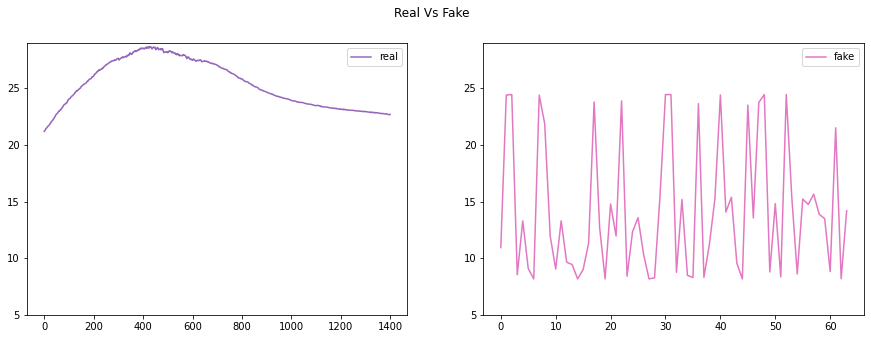

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Real Vs Fake')
ax1.plot(df_train[-1400:], 'tab:purple', label='real')
ax2.plot(torch.reshape(generated_data.cpu().detach(), (64,1)) .numpy(), 'tab:pink', label = 'fake')

ax1.set_ylim(5, 29)
ax2.set_ylim(5, 29)

ax1.legend()
ax2.legend()


In [15]:
generated_data.cpu().detach().shape

torch.Size([64, 1, 1])